# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [3]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [4]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


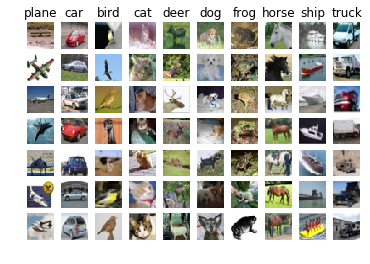

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [7]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


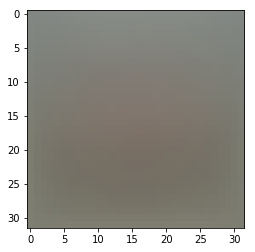

In [8]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [9]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [10]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [11]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.119491


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [12]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 45.120696 analytic: 45.120696, relative error: 2.603551e-12
numerical: 3.646267 analytic: 3.646267, relative error: 8.689041e-11
numerical: 18.001116 analytic: 18.001116, relative error: 9.919055e-12
numerical: -10.908466 analytic: -10.908466, relative error: 3.539168e-11
numerical: -41.104492 analytic: -41.104492, relative error: 9.648842e-12
numerical: -26.600103 analytic: -26.600103, relative error: 2.422734e-11
numerical: -0.281640 analytic: -0.281640, relative error: 6.084287e-10
numerical: -16.438392 analytic: -16.438392, relative error: 2.761230e-11
numerical: -47.874649 analytic: -47.874649, relative error: 2.491333e-12
numerical: 22.365358 analytic: 22.365358, relative error: 1.037617e-11
numerical: 18.343518 analytic: 18.343518, relative error: 2.466406e-11
numerical: 15.274524 analytic: 15.274524, relative error: 4.205184e-12
numerical: 7.950174 analytic: 7.950174, relative error: 2.247389e-11
numerical: 25.805258 analytic: 25.805258, relative error: 6.600299e-12


### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** * When the margins are zero, the analytic gradient is zero and the weights matrix will not update.
However, the numerical gradient may have a big swing since, the change in loss can be big.
*

In [13]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.119491e+00 computed in 0.103015s
Vectorized loss: 9.119491e+00 computed in 0.008645s
difference: 0.000000


In [14]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.136485s
Vectorized loss and gradient: computed in 0.008791s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [15]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 789.519923
iteration 100 / 1500: loss 287.031357
iteration 200 / 1500: loss 108.582772
iteration 300 / 1500: loss 42.666986
iteration 400 / 1500: loss 19.098686
iteration 500 / 1500: loss 10.165944
iteration 600 / 1500: loss 6.972582
iteration 700 / 1500: loss 6.433026
iteration 800 / 1500: loss 5.467373
iteration 900 / 1500: loss 5.240916
iteration 1000 / 1500: loss 4.844341
iteration 1100 / 1500: loss 5.615340
iteration 1200 / 1500: loss 5.252463
iteration 1300 / 1500: loss 5.252963
iteration 1400 / 1500: loss 5.585350
That took 7.044601s


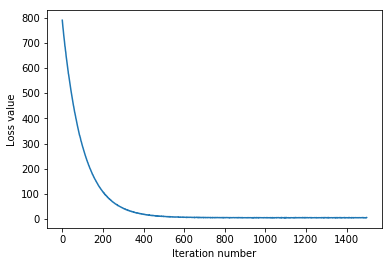

In [16]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [17]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.364673
validation accuracy: 0.363000


In [18]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [0.9e-07, 1.10e-07]
regularization_strengths = [0.54e+04, 1e+04]                                                                        e+04 , 1e+04]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
from cs231n.classifiers import LinearSVM
import numpy as np

 #run a random search for best hyperparameters
num_trial  = 100
    
for i in range(num_trial):
    learning_rate = (learning_rates[1] - learning_rates[0]) * np.random.random_sample() + learning_rates[0]
    reg = (regularization_strengths[1] - regularization_strengths[0]) * np.random.random_sample() + regularization_strengths[0]
    print('### Experiment ', i, ': Learning rate, %e' 
                              %learning_rate, ', Regularization Strength, %f'%reg, ' ###')

    svm = LinearSVM()
    lost_hist = svm.train(X_train, y_train, learning_rate, reg,
                  num_iters=1500, verbose=True)

    y_train_pred = svm.predict(X_train)
    training_accuracy = np.mean(y_train == y_train_pred)

    y_val_pred = svm.predict(X_val)
    validation_accuracy = np.mean(y_val == y_val_pred)

    results[(learning_rate, reg)] = (training_accuracy, validation_accuracy)

    if validation_accuracy > best_val:
        best_val = validation_accuracy
        best_svm = svm


        
        

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

### Experiment  0 : Learning rate, 1.157335e-07 , Regularization Strength, 8227.040481  ###
iteration 0 / 1500: loss 274.088841
iteration 100 / 1500: loss 181.885967
iteration 200 / 1500: loss 123.550201
iteration 300 / 1500: loss 85.683959
iteration 400 / 1500: loss 59.556548
iteration 500 / 1500: loss 42.369492
iteration 600 / 1500: loss 29.607846
iteration 700 / 1500: loss 22.163813
iteration 800 / 1500: loss 16.857519
iteration 900 / 1500: loss 13.346913
iteration 1000 / 1500: loss 11.040907
iteration 1100 / 1500: loss 9.009244
iteration 1200 / 1500: loss 7.485100
iteration 1300 / 1500: loss 6.099947
iteration 1400 / 1500: loss 6.416239
### Experiment  1 : Learning rate, 8.067160e-08 , Regularization Strength, 13745.593699  ###
iteration 0 / 1500: loss 446.350044
iteration 100 / 1500: loss 280.182403
iteration 200 / 1500: loss 180.986920
iteration 300 / 1500: loss 116.484436
iteration 400 / 1500: loss 76.246288
iteration 500 / 1500: loss 50.537558
iteration 600 / 1500: loss 34.0647

iteration 900 / 1500: loss 12.715766
iteration 1000 / 1500: loss 9.879928
iteration 1100 / 1500: loss 8.735284
iteration 1200 / 1500: loss 6.977922
iteration 1300 / 1500: loss 6.735731
iteration 1400 / 1500: loss 5.840599
### Experiment  13 : Learning rate, 9.117704e-08 , Regularization Strength, 15882.923681  ###
iteration 0 / 1500: loss 504.141644
iteration 100 / 1500: loss 279.628779
iteration 200 / 1500: loss 157.342267
iteration 300 / 1500: loss 89.549041
iteration 400 / 1500: loss 52.414428
iteration 500 / 1500: loss 31.559215
iteration 600 / 1500: loss 19.829408
iteration 700 / 1500: loss 13.119270
iteration 800 / 1500: loss 9.534819
iteration 900 / 1500: loss 7.798629
iteration 1000 / 1500: loss 6.889098
iteration 1100 / 1500: loss 5.839616
iteration 1200 / 1500: loss 5.758031
iteration 1300 / 1500: loss 4.858171
iteration 1400 / 1500: loss 5.011262
### Experiment  14 : Learning rate, 9.001022e-08 , Regularization Strength, 10072.046894  ###
iteration 0 / 1500: loss 334.905271


iteration 300 / 1500: loss 106.404811
iteration 400 / 1500: loss 70.082214
iteration 500 / 1500: loss 46.746823
iteration 600 / 1500: loss 31.502609
iteration 700 / 1500: loss 22.169465
iteration 800 / 1500: loss 16.565538
iteration 900 / 1500: loss 11.802319
iteration 1000 / 1500: loss 9.701342
iteration 1100 / 1500: loss 8.173281
iteration 1200 / 1500: loss 6.782773
iteration 1300 / 1500: loss 6.394632
iteration 1400 / 1500: loss 5.681029
### Experiment  26 : Learning rate, 9.290717e-08 , Regularization Strength, 15943.092905  ###
iteration 0 / 1500: loss 518.922582
iteration 100 / 1500: loss 280.562178
iteration 200 / 1500: loss 156.710955
iteration 300 / 1500: loss 87.799765
iteration 400 / 1500: loss 50.365253
iteration 500 / 1500: loss 30.616989
iteration 600 / 1500: loss 19.142952
iteration 700 / 1500: loss 12.515957
iteration 800 / 1500: loss 9.441617
iteration 900 / 1500: loss 7.012696
iteration 1000 / 1500: loss 6.299936
iteration 1100 / 1500: loss 5.227836
iteration 1200 / 1

iteration 1400 / 1500: loss 7.068729
### Experiment  38 : Learning rate, 1.214145e-07 , Regularization Strength, 11656.033361  ###
iteration 0 / 1500: loss 385.046840
iteration 100 / 1500: loss 214.706175
iteration 200 / 1500: loss 122.326248
iteration 300 / 1500: loss 71.419890
iteration 400 / 1500: loss 42.066348
iteration 500 / 1500: loss 26.017577
iteration 600 / 1500: loss 16.448201
iteration 700 / 1500: loss 11.944617
iteration 800 / 1500: loss 8.356240
iteration 900 / 1500: loss 7.634918
iteration 1000 / 1500: loss 6.026216
iteration 1100 / 1500: loss 6.237485
iteration 1200 / 1500: loss 5.608071
iteration 1300 / 1500: loss 5.377897
iteration 1400 / 1500: loss 5.458217
### Experiment  39 : Learning rate, 9.388667e-08 , Regularization Strength, 7969.259838  ###
iteration 0 / 1500: loss 263.674803
iteration 100 / 1500: loss 186.475939
iteration 200 / 1500: loss 140.307751
iteration 300 / 1500: loss 102.271234
iteration 400 / 1500: loss 78.054597
iteration 500 / 1500: loss 57.82035

iteration 700 / 1500: loss 18.489992
iteration 800 / 1500: loss 13.139672
iteration 900 / 1500: loss 9.999574
iteration 1000 / 1500: loss 7.514189
iteration 1100 / 1500: loss 6.638065
iteration 1200 / 1500: loss 6.412117
iteration 1300 / 1500: loss 5.586794
iteration 1400 / 1500: loss 5.380522
### Experiment  51 : Learning rate, 8.325252e-08 , Regularization Strength, 14588.125625  ###
iteration 0 / 1500: loss 473.007905
iteration 100 / 1500: loss 285.167298
iteration 200 / 1500: loss 177.250379
iteration 300 / 1500: loss 110.167017
iteration 400 / 1500: loss 69.236308
iteration 500 / 1500: loss 44.050992
iteration 600 / 1500: loss 28.835937
iteration 700 / 1500: loss 18.682323
iteration 800 / 1500: loss 13.810193
iteration 900 / 1500: loss 10.479300
iteration 1000 / 1500: loss 8.752498
iteration 1100 / 1500: loss 7.529667
iteration 1200 / 1500: loss 6.243239
iteration 1300 / 1500: loss 6.073844
iteration 1400 / 1500: loss 5.940848
### Experiment  52 : Learning rate, 8.947165e-08 , Reg

iteration 100 / 1500: loss 169.258605
iteration 200 / 1500: loss 126.134944
iteration 300 / 1500: loss 93.631994
iteration 400 / 1500: loss 70.073131
iteration 500 / 1500: loss 52.643148
iteration 600 / 1500: loss 39.940090
iteration 700 / 1500: loss 30.416418
iteration 800 / 1500: loss 23.707292
iteration 900 / 1500: loss 18.421039
iteration 1000 / 1500: loss 14.714194
iteration 1100 / 1500: loss 11.576441
iteration 1200 / 1500: loss 10.609356
iteration 1300 / 1500: loss 8.823383
iteration 1400 / 1500: loss 7.727508
### Experiment  64 : Learning rate, 1.185908e-07 , Regularization Strength, 8127.131958  ###
iteration 0 / 1500: loss 274.230318
iteration 100 / 1500: loss 180.867419
iteration 200 / 1500: loss 123.486047
iteration 300 / 1500: loss 85.052284
iteration 400 / 1500: loss 58.395514
iteration 500 / 1500: loss 40.631908
iteration 600 / 1500: loss 29.328365
iteration 700 / 1500: loss 21.397923
iteration 800 / 1500: loss 15.510130
iteration 900 / 1500: loss 12.441560
iteration 100

iteration 1200 / 1500: loss 6.013936
iteration 1300 / 1500: loss 5.187396
iteration 1400 / 1500: loss 5.464349
### Experiment  76 : Learning rate, 9.128784e-08 , Regularization Strength, 6789.221699  ###
iteration 0 / 1500: loss 228.099615
iteration 100 / 1500: loss 170.340932
iteration 200 / 1500: loss 132.353762
iteration 300 / 1500: loss 103.829611
iteration 400 / 1500: loss 82.967746
iteration 500 / 1500: loss 65.228850
iteration 600 / 1500: loss 51.201709
iteration 700 / 1500: loss 40.609771
iteration 800 / 1500: loss 34.020529
iteration 900 / 1500: loss 26.552890
iteration 1000 / 1500: loss 22.167059
iteration 1100 / 1500: loss 17.822438
iteration 1200 / 1500: loss 14.598264
iteration 1300 / 1500: loss 13.343905
iteration 1400 / 1500: loss 10.666183
### Experiment  77 : Learning rate, 1.151052e-07 , Regularization Strength, 12502.978331  ###
iteration 0 / 1500: loss 407.866201
iteration 100 / 1500: loss 224.911165
iteration 200 / 1500: loss 126.462182
iteration 300 / 1500: loss 7

iteration 500 / 1500: loss 51.327614
iteration 600 / 1500: loss 39.949427
iteration 700 / 1500: loss 31.271164
iteration 800 / 1500: loss 24.530827
iteration 900 / 1500: loss 19.503332
iteration 1000 / 1500: loss 15.892588
iteration 1100 / 1500: loss 12.922134
iteration 1200 / 1500: loss 11.275897
iteration 1300 / 1500: loss 9.698569
iteration 1400 / 1500: loss 8.344629
### Experiment  89 : Learning rate, 1.121351e-07 , Regularization Strength, 6398.111565  ###
iteration 0 / 1500: loss 219.336969
iteration 100 / 1500: loss 156.846584
iteration 200 / 1500: loss 116.992267
iteration 300 / 1500: loss 88.877996
iteration 400 / 1500: loss 67.587947
iteration 500 / 1500: loss 51.535366
iteration 600 / 1500: loss 39.736320
iteration 700 / 1500: loss 31.259592
iteration 800 / 1500: loss 24.394187
iteration 900 / 1500: loss 19.536811
iteration 1000 / 1500: loss 15.144970
iteration 1100 / 1500: loss 12.775589
iteration 1200 / 1500: loss 10.692197
iteration 1300 / 1500: loss 9.569556
iteration 14

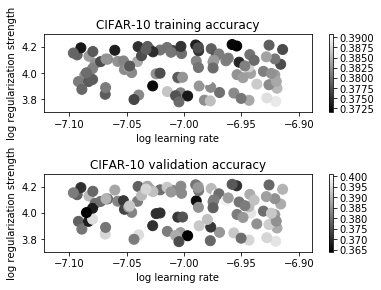

In [20]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.subplots_adjust(wspace=1.6,hspace=0.8)
plt.show()

In [21]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.386000


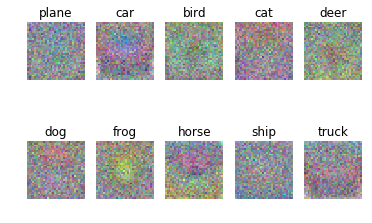

In [22]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *they are composed by basically those examples  we don't predict correctly in the training process.*